In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from matplotlib import animation
import matplotlib.image as mpimg

# Constants
g = 9.81  # Gravity (m/s^2)
m = 0.2777
k = 0.00005 #Coeff of lift for individual rotor)
Ixx = 0.02 # Mx
Iyy = 0.02  # My
Izz = 0.02  # Mz
L = 0.2  # Distance from the center of mass to each rotor (m)
Kt = 1  # Thrust coefficient
Kq = 0.1  # Torque coefficient (yaw)

# Function to calculate the state derivative (equations of motion)
def quadcopter_dynamics(state, t, program, u):

  if program == 'takeoffhover':
    x, y, z, phi, theta, psi, vx, vy, vz, p, q, r = state

    thrust_1, thrust_2, thrust_3, thrust_4 = u

    # Calculate total thrust and moments
    total_thrust = (thrust_1 + thrust_2 + thrust_3 + thrust_4)
    moment_x = L * (-thrust_1 + thrust_3)
    moment_y = L * (-thrust_2 + thrust_4)
    moment_z = Kq * (thrust_1 - thrust_2 + thrust_3 - thrust_4)

    target_alt = 0.5
    target_fwd = 5
    target_side = 5
    target_yaw = 0

    #Climb
    s = 25*np.sqrt(target_alt)
    if(t<s):
      total_thrust = total_thrust + total_thrust*0.001*np.sin(2*np.pi*t/s)
    else:
      total_thrust = (thrust_1 + thrust_2 + thrust_3 + thrust_4)




    R_x = np.array([[1, 0, 0],
                    [0, np.cos(phi), -np.sin(phi)],
                    [0, np.sin(phi), np.cos(phi)]])
    R_y = np.array([[np.cos(theta), 0, np.sin(theta)],
                    [0, 1, 0],
                    [-np.sin(theta), 0, np.cos(theta)]])
    R_z = np.array([[np.cos(psi), -np.sin(psi), 0],
                    [np.sin(psi), np.cos(psi), 0],
                    [0, 0, 1]])
    R = np.dot(R_z, np.dot(R_y, R_x))

    # Calculate acceleration in world frame
    acceleration_world = np.array([0, 0, -g]) + np.dot(R, np.array([0, 0, total_thrust / m]))


    # Angular velocity derivatives
    dp_dt = (moment_x / Ixx) + (q * r * (Iyy - Izz) / Ixx)
    dq_dt = (moment_y / Iyy) + (p * r * (Izz - Ixx) / Iyy)
    dr_dt = (moment_z / Izz) + (p * q * (Ixx - Iyy) / Izz)

    return [vx, vy, vz, p, q, r, acceleration_world[0], acceleration_world[1], acceleration_world[2], dp_dt, dq_dt, dr_dt]

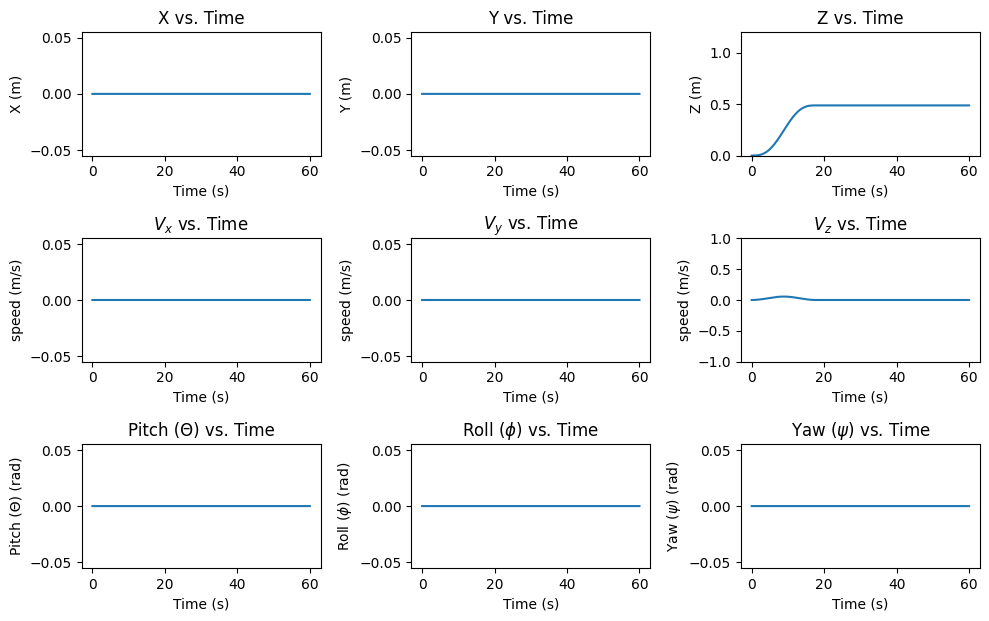

Text(0.5, 0.92, 'Trajectory, program = takeoffhover')

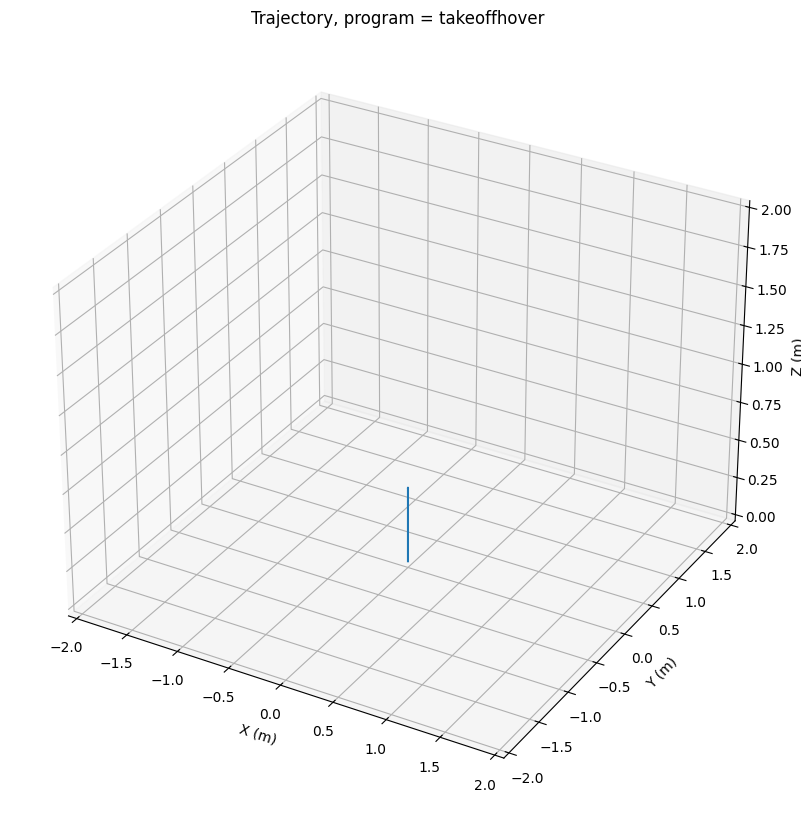

In [3]:
# Simulation parameters
t_final = 60  # Simulation time (s)
dt = 0.01  # Time step (s)
t = np.arange(0.00001, t_final, dt)

program = 'takeoffhover'


if program =='takeoffhover':
  # Initial state (x, y, z, phi, theta, psi, vx, vy, vz, p, q, r)
  initial_state = [0, 0, 0,0,     0,   0,0,  0,  0, 0, 0, 0]
  Tz = m*g
  Treq = np.sqrt(Tz**2)
  thrust_1 = Treq / 4
  thrust_2 = Treq / 4
  thrust_3 = Treq / 4
  thrust_4 = Treq / 4
  u = [thrust_1, thrust_2, thrust_3, thrust_4]
# Simulate the quadcopter

states = odeint(quadcopter_dynamics, initial_state, t, args=(program,u))

# Extract position and orientation data
x = states[:, 0]
y = states[:, 1]
z = states[:, 2]
phi = states[:, 3]
theta = states[:, 4]
psi = states[:, 5]
vx = states[:,6]
vy = states[:,7]
vz = states[:,8]
p = states[:,9]
q = states[:,10]
r = states[:,11]

# Plotting
plt.figure(figsize=(10, 10))

# X vs. Time
plt.subplot(5,3,1)
plt.plot(t, x)
plt.xlabel('Time (s)')
plt.ylabel('X (m)')
plt.title('X vs. Time')

# Y vs. Time
plt.subplot(5,3,2)
plt.plot(t, y)
plt.xlabel('Time (s)')
plt.ylabel('Y (m)')
plt.title('Y vs. Time')

# Z vs. Time
plt.subplot(5,3,3)
plt.plot(t, z)
plt.ylim(0,1.2)
plt.xlabel('Time (s)')
plt.ylabel('Z (m)')
plt.title('Z vs. Time')

# Vx vs. Time
plt.subplot(5,3,4)
plt.plot(t, vx)
plt.xlabel('Time (s)')
plt.ylabel('speed (m/s)')
plt.title('$V_x$ vs. Time')

# Vy vs. Time
plt.subplot(5,3,5)
plt.plot(t, vy)
plt.xlabel('Time (s)')
plt.ylabel('speed (m/s)')
plt.title('$V_y$ vs. Time')

# Vz vs. Time
plt.subplot(5,3,6)
plt.plot(t, vz)
plt.ylim(-1,1)
plt.xlabel('Time (s)')
plt.ylabel('speed (m/s)')
plt.title('$V_z$ vs. Time')

# Pitch (theta) vs. Time
plt.subplot(5,3,7)
plt.plot(t, theta)
plt.xlabel('Time (s)')
plt.ylabel('Pitch (\u0398) (rad)')
plt.title('Pitch (\u0398) vs. Time')

# Roll (phi) vs. Time
plt.subplot(5,3,8)
plt.plot(t, phi)
plt.xlabel('Time (s)')
plt.ylabel('Roll ($\phi$) (rad)')
plt.title('Roll ($\phi$) vs. Time')

# Yaw (psi) vs. Time
plt.subplot(5,3,9)
plt.plot(t, psi)
plt.xlabel('Time (s)')
plt.ylabel('Yaw ($\psi$) (rad)')
plt.title('Yaw ($\psi$) vs. Time')

plt.tight_layout()
plt.show()


# 3D Trajectory
fig2 = plt.figure(figsize = (10,11))
ax = fig2.add_subplot(111,projection='3d')
plt.plot(x, y, z)
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_zlim(0,2)
ax.set_ylim(-2,2)
ax.set_xlim(-2,2)
ax.set_title(f'Trajectory, program = {program}')
